# Normal Evaluation

In [1]:
import os
from torchvision import transforms
from data_utils import Normalization, ToTensor
from data_utils import Dataset, DataLoader

data_dir = '/mnt/hdd1/c-MET_datasets/Lung_c-MET IHC_scored/DL-based_tumor_seg_dataset'
batch_size = 18 # number of samples in an WSI (or a source image)

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset = Dataset(data_dir=os.path.join(data_dir, 'test'), transform = transform)
loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

In [2]:
import torch
from model import UNet
import torch.nn as nn

rank = 4
torch.cuda.set_device(rank)

device = torch.device(f'cuda:{rank}')
net = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)

ckpt_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/checkpoint'

def net_test_load(ckpt_dir, net, epoch = 0):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    print(f'{ckpt_lst[epoch-1]}')
    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[epoch-1]), map_location=device)
    
    net.load_state_dict(dict_model['net'])

    return net

net = net_test_load(ckpt_dir = ckpt_dir, net = net, epoch = 120) # 저장된 네트워크 불러오기


model_epoch120.pth


In [3]:
import numpy as np

fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x*std) + mean
fn_classifier = lambda x : 1.0 * (x > 0.5)

results = []

with torch.no_grad(): 
    net.eval() 
    loss_arr = []
    
    
    for batch, data in enumerate(loader, 1):
        # forward
        label = data['label'].to(device)
        input = data['input'].to(device)
        output = net(input)

        # loss 
        loss = fn_loss(output,label)
        loss_arr += [loss.item()]
        
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        label = np.squeeze(fn_tonumpy(label), axis=-1)
        pred = np.squeeze(fn_tonumpy(fn_classifier(output)), axis=-1)
        prob = np.squeeze(fn_tonumpy(output), axis=-1)
        results.append((input, label, pred, prob))
        
    print('test : Loss %.4f'%(np.mean(loss_arr)))

test : Loss 0.2644


In [43]:
from sklearn.metrics import roc_auc_score 

def get_performance(label, output, predict, isprint = False):

    label = label.flatten()
    output = output.flatten()
    predict = predict.flatten()

    def get_target_value_index(array, target_value):
        return set([i for i, v in enumerate(array) if v == target_value])

    C1, C0 = get_target_value_index(label, 1), get_target_value_index(label, 0)
    P1, P0 = get_target_value_index(predict, 1), get_target_value_index(predict, 0)

    TP, TN = C1 & P1, C0 & P0 
    FP, FN = P1 - C1, P0 - C0

    accuracy = (len(TP) + len(TN))/(len(C1) + len(C0))

    recall, precision, recall = np.NaN, np.NaN, np.NAN
    if len(C1) != 0:    recall = len(TP) / len(C1)
    if len(P1) != 0:    precision = len(TP) / len(P1)

    if recall != np.NaN and precision != np.NaN:
        f1_score = 2*recall*precision/(recall + precision)

    try: auc_score = roc_auc_score(label, output)
    except: auc_score = np.NaN

    if isprint:
        print(f'accuracy: {accuracy:.3f} | recall: {recall:.3f} | precision: {precision:.3f} | f1 score: {f1_score:.3f} | AUC score: {auc_score:.3f}')

    return accuracy, recall, precision, f1_score, auc_score

In [50]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

def make_heatmap(output):
    output = output-output.min()
    output = output/output.max()
    heatmap = cm.jet(output)
    return heatmap

save_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/output'

try: os.makedirs(save_dir)
except: pass

nrow, ncol = 3, 6

patch_level_performance = []
wsi_level_performance = []
for i, result in enumerate(results):

    # visualization on WSI (or source image)-level
    sample = np.empty((nrow*256, ncol*256, 3))
    label = np.empty((nrow*256, ncol*256))
    predict = np.empty((nrow*256, ncol*256))
    output = np.empty((nrow*256, ncol*256))

    x, y, pred, prob = result
    
    for j, (x_j, y_j, pred_j, prob_j) in enumerate(zip(x, y, pred, prob)):
    
        row = j % nrow
        col = j // nrow

        performance = get_performance(y_j, prob_j, pred_j)
        patch_level_performance.append(performance)

        sample[row*256:(row+1)*256, col*256:(col+1)*256, :] = x_j
        label[row*256:(row+1)*256, col*256:(col+1)*256] = y_j
        predict[row*256:(row+1)*256, col*256:(col+1)*256] = pred_j
        output[row*256:(row+1)*256, col*256:(col+1)*256] = prob_j

    wsi_level_performance.append(get_performance(label, output, predict, isprint = True))

    # comparison plot 
    plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.subplot(1, 3, 1)
    plt.imshow(sample)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(label*255, cmap='gray', vmax = 255, vmin = 0)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    # plt.imshow(predict*255, cmap='gray', vmax = 255, vmin = 0)
    plt.imshow(output, cmap = 'jet')
    plt.axis('off')
    # plt.savefig(f'{save_dir}/{i+1}__plot.png', bbox_inches = 'tight')
    plt.show()
    plt.close()

    # save
    # sample = Image.fromarray(np.uint8(sample*255))
    # label = Image.fromarray(np.uint8(label*255))
    # predict = Image.fromarray(np.uint8(predict*255))
    # heatmap = make_heatmap(output)
    # heatmap = Image.fromarray(np.uint8(heatmap*255)).convert('RGB')

    # sample.save(f'{save_dir}/{i+1}_sample.jpg')
    # label.save(f'{save_dir}/{i+1}_label.jpg')
    # predict.save(f'{save_dir}/{i+1}_predict.jpg')
    # heatmap.save(f'{save_dir}/{i+1}_heatmap.jpg') 

patch_level_performance_ = np.nanmean(np.concatenate([patch_level_performance]), axis = 0)
wsi_level_performance_ = np.nanmean(np.concatenate([wsi_level_performance]), axis = 0)

print(f'patch-level average (nanmean) | accuracy: {patch_level_performance_[0]:.3f} | recall: {patch_level_performance_[1]:.3f} | precision: {patch_level_performance_[2]:.3f} | f1 score: {patch_level_performance_[3]:.3f} | AUC score: {patch_level_performance_[4]:.3f}')
print(f'wsi-level average (nanmean) | accuracy: {wsi_level_performance_[0]:.3f} | recall: {wsi_level_performance_[1]:.3f} | precision: {wsi_level_performance_[2]:.3f} | f1 score: {wsi_level_performance_[3]:.3f} | AUC score: {wsi_level_performance_[4]:.3f}')


accuracy: 0.926 | recall: 0.917 | precision: 0.760 | f1 score: 0.832 | AUC score: nan
patch-level average (nanmean) | accuracy: 0.922 | recall: 0.854 | precision: 0.783 | f1 score: 0.838 | AUC score: 0.962
wsi-level average (nanmean) | accuracy: 0.926 | recall: 0.917 | precision: 0.760 | f1 score: 0.832 | AUC score: nan


/tmp/ipykernel_32550/3939480410.py:35: RuntimeWarning: Mean of empty slice
  wsi_level_performance_ = np.nanmean(np.concatenate([wsi_level_performance]), axis = 0)


In [32]:

import csv

def save_performance_as_csv(save_dir: str, performance: np.array or list, csv_name: str):

    with open(f'{save_dir}/{csv_name}.csv', 'w', newline ='') as csvfile:
        performance_writer = csv.writer(csvfile, delimiter = ' ', quotechar = '|', quoting=csv.QUOTE_MINIMAL)

        performance_writer.writerow(['accuracy', 'recall', 'precision', 'f1 score', 'AUC score'])
        performance_writer.writerow([score for score in performance])

save_performance_as_csv(save_dir=save_dir, performance=patch_level_performance, csv_name = "input-level_average_performance")
save_performance_as_csv(save_dir=save_dir, performance=wsi_level_performance, csv_name = "source-level_average_performance")

# K-fold CV

In [59]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from data_utils import Normalization, ToTensor
from data_utils import Dataset, DataLoader
from model import UNet
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

def net_test_load(ckpt_dir, net, epoch = 0, device = torch.device('cuda:0')):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    print(f'{ckpt_lst[epoch-1]}')
    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[epoch-1]), map_location=device)
    
    net.load_state_dict(dict_model['net'])

    return net

def get_performance(label, output, predict, isprint = False):

    label = label.flatten()
    output = output.flatten()
    predict = predict.flatten()

    def get_target_value_index(array, target_value):
        return set([i for i, v in enumerate(array) if v == target_value])

    C1, C0 = get_target_value_index(label, 1), get_target_value_index(label, 0)
    P1, P0 = get_target_value_index(predict, 1), get_target_value_index(predict, 0)

    TP, TN = C1 & P1, C0 & P0 
    FP, FN = P1 - C1, P0 - C0

    accuracy = (len(TP) + len(TN))/(len(C1) + len(C0))

    recall, precision, recall = np.NaN, np.NaN, np.NAN
    if len(C1) != 0:    recall = len(TP) / len(C1)
    if len(P1) != 0:    precision = len(TP) / len(P1)

    if recall != np.NaN and precision != np.NaN:
        f1_score = 2*recall*precision/(recall + precision)

    try: auc_score = roc_auc_score(label, output)
    except: auc_score = np.NaN

    if isprint:
        print(f'accuracy: {accuracy:.3f} | recall: {recall:.3f} | precision: {precision:.3f} | f1 score: {f1_score:.3f} | AUC score: {auc_score:.3f}')

    return accuracy, recall, precision, f1_score, auc_score

def make_heatmap(output):
    output = output-output.min()
    output = output/output.max()
    heatmap = cm.jet(output)
    return heatmap

k_fold = 5
batch_size = 18
nrow, ncol = 3, 6

rank = 0
torch.cuda.set_device(rank)
device = torch.device(f'cuda:{rank}')

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x*std) + mean
fn_classifier = lambda x : 1.0 * (x > 0.5)

patch_level_performances = []
wsi_level_performances = []

model_select = [94, 100, 83, 93, 93]

for i in range(k_fold):
    print(f'{i+1}-fold')

    data_dir = f'/mnt/hdd1/c-MET_datasets/Lung_c-MET IHC_scored/DL-based_tumor_seg_dataset/{i+1}-fold'
    ckpt_dir = f'/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/{i+1}-fold/checkpoint'

    dataset = Dataset(data_dir=os.path.join(data_dir, 'valid'), transform = transform)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

    net = UNet().to(device)
    fn_loss = nn.BCEWithLogitsLoss().to(device)

    net = net_test_load(ckpt_dir = ckpt_dir, net = net, epoch = model_select[i], device=device)

    results = []
    with torch.no_grad(): 
        net.eval() 
        loss_arr = []
        
        for batch, data in enumerate(loader, 1):
            # forward
            label = data['label'].to(device)
            input = data['input'].to(device)
            output = net(input)

            # loss 
            loss = fn_loss(output,label)
            loss_arr += [loss.item()]
            
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            label = np.squeeze(fn_tonumpy(label), axis=-1)
            pred = np.squeeze(fn_tonumpy(fn_classifier(output)), axis=-1)
            prob = np.squeeze(fn_tonumpy(output), axis=-1)
            results.append((input, label, pred, prob))
            
        print('test : Loss %.4f'%(np.mean(loss_arr)))

    save_dir = f'/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/{i+1}-fold/output'

    try: os.makedirs(save_dir)
    except: pass

    patch_level_performance = []
    wsi_level_performance = []
    for i, result in enumerate(results):
        # visualization on WSI (or source image)-level
        sample = np.empty((nrow*256, ncol*256, 3))
        label = np.empty((nrow*256, ncol*256))
        predict = np.empty((nrow*256, ncol*256))
        output = np.empty((nrow*256, ncol*256))

        x, y, pred, prob = result
        
        for j, (x_j, y_j, pred_j, prob_j) in enumerate(zip(x, y, pred, prob)):
        
            row = j % nrow
            col = j // nrow

            performance = get_performance(y_j, prob_j, pred_j)
            patch_level_performance.append(performance)

            sample[row*256:(row+1)*256, col*256:(col+1)*256, :] = x_j
            label[row*256:(row+1)*256, col*256:(col+1)*256] = y_j
            predict[row*256:(row+1)*256, col*256:(col+1)*256] = pred_j
            output[row*256:(row+1)*256, col*256:(col+1)*256] = prob_j

        wsi_level_performance.append(get_performance(label, output, predict, isprint = True)) 

        plt.figure(figsize=(30, 30))
        plt.axis('off')
        plt.subplot(1, 3, 1)
        plt.imshow(sample)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(label*255, cmap='gray', vmax = 255, vmin = 0)
        plt.axis('off')
        plt.subplot(1, 3, 3)
        # plt.imshow(predict*255, cmap='gray', vmax = 255, vmin = 0)
        plt.imshow(output, cmap = 'jet')
        plt.axis('off')
        plt.savefig(f'{save_dir}/{i+1}__plot.png', bbox_inches = 'tight')

        # plt.show()
        plt.close()

        # sample = Image.fromarray(np.uint8(sample*255))
        # label = Image.fromarray(np.uint8(label*255))
        # predict = Image.fromarray(np.uint8(predict*255))
        # heatmap = make_heatmap(output)
        # heatmap = Image.fromarray(np.uint8(heatmap*255)).convert('RGB')

        # sample.save(f'{save_dir}/{i+1}_sample.jpg')
        # label.save(f'{save_dir}/{i+1}_label.jpg')
        # predict.save(f'{save_dir}/{i+1}_predict.jpg')
        # heatmap.save(f'{save_dir}/{i+1}_heatmap.jpg')

    patch_level_performance = np.nanmean(np.concatenate([patch_level_performance]), axis = 0)
    wsi_level_performance = np.nanmean(np.concatenate([wsi_level_performance]), axis = 0)

    print(f'patch-level average | accuracy: {patch_level_performance[0]:.3f} | recall: {patch_level_performance[1]:.3f} | precision: {patch_level_performance[2]:.3f} | f1 score: {patch_level_performance[3]:.3f} | AUC score: {patch_level_performance[4]:.3f}')
    print(f'wsi-level average | accuracy: {wsi_level_performance[0]:.3f} | recall: {wsi_level_performance[1]:.3f} | precision: {wsi_level_performance[2]:.3f} | f1 score: {wsi_level_performance[3]:.3f} | AUC score: {wsi_level_performance[4]:.3f}')

    patch_level_performances.append(patch_level_performance)
    wsi_level_performances.append(wsi_level_performance)

1-fold
model_epoch94.pth
test : Loss 0.2460
accuracy: 0.942 | recall: 0.974 | precision: 0.963 | f1 score: 0.968 | AUC score: 0.949
accuracy: 0.834 | recall: 0.936 | precision: 0.838 | f1 score: 0.884 | AUC score: 0.886
accuracy: 0.955 | recall: 0.961 | precision: 0.979 | f1 score: 0.970 | AUC score: 0.990
accuracy: 0.933 | recall: 0.971 | precision: 0.946 | f1 score: 0.958 | AUC score: 0.977
patch-level average | accuracy: 0.916 | recall: 0.957 | precision: 0.927 | f1 score: 0.940 | AUC score: 0.942
wsi-level average | accuracy: 0.916 | recall: 0.960 | precision: 0.932 | f1 score: 0.945 | AUC score: 0.950
2-fold
model_epoch100.pth
test : Loss 0.1564
accuracy: 0.948 | recall: 0.984 | precision: 0.961 | f1 score: 0.972 | AUC score: 0.904
accuracy: 0.905 | recall: 0.929 | precision: 0.936 | f1 score: 0.933 | AUC score: 0.964
accuracy: 0.982 | recall: 0.986 | precision: 0.996 | f1 score: 0.991 | AUC score: 0.995
accuracy: 0.916 | recall: 0.911 | precision: 0.938 | f1 score: 0.924 | AUC sc

In [60]:
patch_level_performances

[array([0.91598892, 0.957171  , 0.9273052 , 0.9404774 , 0.94153898]),
 array([0.93771044, 0.95018423, 0.95609913, 0.95238906, 0.95091533]),
 array([0.85295974, 0.78899714, 0.9287782 , 0.84894495, 0.94087914]),
 array([0.90348477, 0.91867616, 0.94613662, 0.9304933 , 0.92064683]),
 array([0.92960231, 0.91148351, 0.87266618, 0.9026785 , 0.96047153])]

In [61]:
np.mean(np.asarray(patch_level_performances), axis = 0)

array([0.90794924, 0.90530241, 0.92619707, 0.91499664, 0.94289036])

In [4]:
np.mean(np.asarray(patch_level_performances), axis = 0)

array([0.89602658, 0.89660812, 0.92067933, 0.90148887, 0.94289036])

In [62]:
wsi_level_performances

[array([0.91598892, 0.96042273, 0.93162429, 0.94527869, 0.9504371 ]),
 array([0.93771044, 0.95280029, 0.95746006, 0.95503874, 0.95948831]),
 array([0.85295974, 0.82587404, 0.94755958, 0.87653106, 0.95219078]),
 array([0.90348477, 0.92101759, 0.94907682, 0.93459809, 0.93687747]),
 array([0.92960231, 0.92398768, 0.9369533 , 0.9303793 , 0.97450344])]

In [63]:
np.mean(np.asarray(wsi_level_performances), axis = 0)

array([0.90794924, 0.91682047, 0.94453481, 0.92836518, 0.95469942])

# Testing at Larger size

In [10]:
import os
import numpy as np

data_dir = '/mnt/hdd1/c-MET_datasets/Lung_c-MET IHC_scored/sample'
batch_size = 18 # number of samples in an WSI (or a source image)

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
data_list = sorted([f for f in os.listdir(data_dir) if 'png' in f])

from PIL import Image

img = Image.open(os.path.join(data_dir, data_list[-1])).convert('RGB')

img = np.array(img)
img = img/255.0
img = img.astype(np.float32)

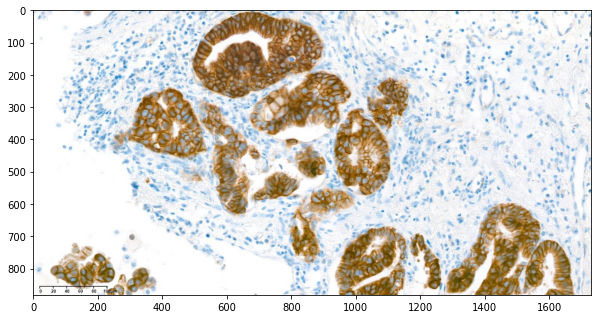

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
plt.imshow(img)

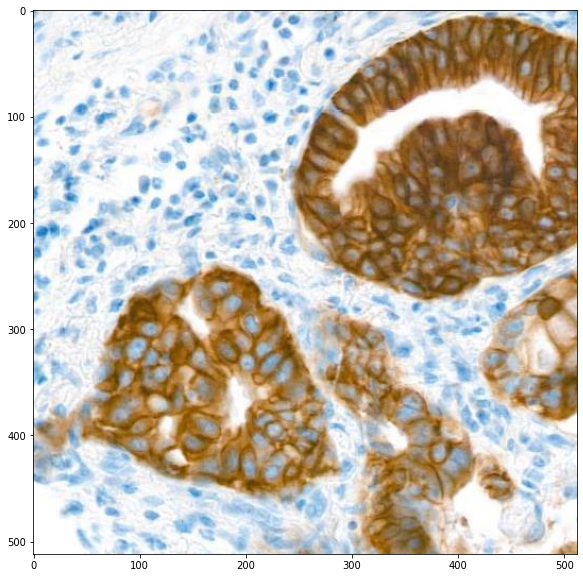

In [46]:
x_start, y_start = 250, 0
size = 512

img_ = img[y_start:y_start+size, x_start:x_start+size, :]

plt.figure(figsize = (10, 10))
plt.imshow(img_)

In [28]:
import torch
from model import UNet
import torch.nn as nn

rank = 4
torch.cuda.set_device(rank)

device = torch.device(f'cuda:{rank}')
net = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)

ckpt_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/checkpoint'

def net_test_load(ckpt_dir, net, epoch = 0):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    print(f'{ckpt_lst[epoch-1]}')
    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[epoch-1]), map_location=device)
    
    net.load_state_dict(dict_model['net'])

    return net

net = net_test_load(ckpt_dir = ckpt_dir, net = net, epoch = 120) # 저장된 네트워크 불러오기


model_epoch120.pth


In [47]:
fn_ToTensor = lambda x: torch.from_numpy(x.transpose((2, 0, 1)).astype(np.float32))
fn_Norm = lambda x, mean, std: (x - mean)/std

img_ = fn_Norm(fn_ToTensor(img_), mean = 0.5, std = 0.5)

In [48]:
img_.size()

torch.Size([3, 512, 512])

In [49]:
img_ = img_.unsqueeze(dim = 0)

img_.size()

torch.Size([1, 3, 512, 512])

In [50]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x*std) + mean
fn_classifier = lambda x : 1.0 * (x > 0.5)

with torch.no_grad(): 
    img_ = img_.to(device)
    output = net(img_)

In [51]:
output = np.squeeze(fn_tonumpy(output), axis = -1)

output.shape

(1, 512, 512)

(1, 512, 512)

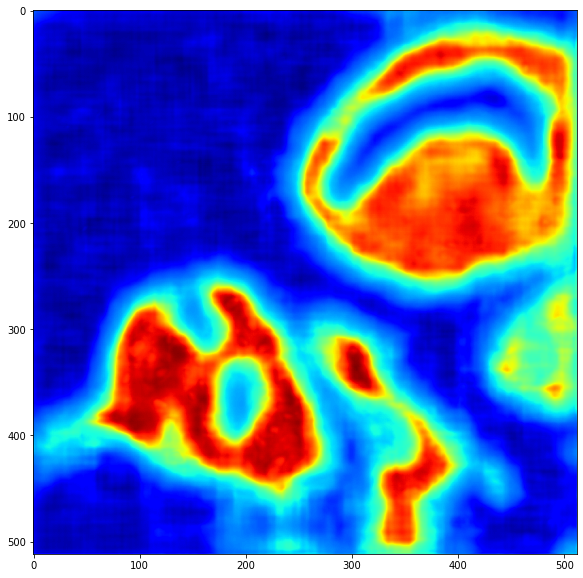

In [52]:
plt.figure(figsize = (10, 10))
plt.imshow(output[0], cmap ='jet')

output.shape

In [53]:

from sklearn.utils import resample

In [82]:
ix = [i for i in range(20)]
train_ix = resample(ix, replace=True, n_samples=10)
train_ix

[9, 18, 1, 3, 9, 12, 11, 2, 0, 13]

In [83]:
test_ix = [x for x in ix if x not in train_ix]
test_ix

[4, 5, 6, 7, 8, 10, 14, 15, 16, 17, 19]